In [4]:
import os
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
sc = MinMaxScaler(feature_range=(0,1)) #normalisasi dari 0 - 1



In [1]:
path_dir = "data"
list_file = os.listdir(path_dir)
asii_data = path_dir+"/"+list_file[2]
amrt_data = path_dir+"/"+list_file[1]
untr_data = path_dir+"/"+list_file[9]
unvr_data = path_dir+"/"+list_file[10]
mapi_data = path_dir+"/"+list_file[7]
inkp_data = path_dir+"/"+list_file[5]
intp_data = path_dir+"/"+list_file[6]
aces_data = path_dir+"/"+list_file[0]
sido_data = path_dir+"/"+list_file[8]
hrum_data = path_dir+"/"+list_file[4]


NameError: name 'os' is not defined

IndentationError: expected an indented block after 'for' statement on line 12 (1832528566.py, line 13)

In [6]:
def data_clean(path_data):
  df = pd.read_csv(path_data)
  df = df.drop('Unnamed: 0', axis=1)
  df = df.sort_values('date', ascending=True)
  df.set_index('date', inplace=True)
  return df

def view_data(df, nama):
  #Menampilkan data close price
  plt.figure(figsize=(16,8))
  sns.lineplot(x=df.index, y=df['close'])
  plt.xlabel('Tanggal', fontsize=20)
  plt.ylabel('Harga Penutupan dalam Rupiah (Rp)', fontsize=20)
  plt.title('Riwayat Harga Penutupan pada Emiten ' + nama)
  plt.savefig('result/'+nama+'_stockprice.png')

def split_data(df, timestep):
  from sklearn.preprocessing import MinMaxScaler
  close = df.iloc[: , 5:6]
  train_set = close.iloc[:485, :].values
  test_set = close.iloc[485:, :].values
  sc = MinMaxScaler(feature_range=(0,1)) #normalisasi dari 0 - 1
  train_set_scaled= sc.fit_transform(train_set)
  x_train = []
  y_train = []
  for i in range(timestep, 485):
    x_train.append(train_set_scaled[i-timestep:i,0])
    y_train.append(train_set_scaled[i,0])
  x_train, y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  return x_train, y_train

def view_loss_accuracy_history(history,nama):
  #Melihat plot evaluasi model
  plt.figure(figsize=(15,6))
  plt.plot(history.history['loss'])
  plt.plot(history.history['accuracy'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Riwayat Train ' + nama)
  plt.savefig('result/'+nama+'_train_history.png')
  #plt.show()
  

def predict(df, timesteps, model):
  df_to_train = df[:485] #data train
  df_to_test = df[485:] #data test
  data_total= pd.concat([df_to_train['close'], df_to_test['close']],  axis=0) #digabungin
  #inputnya dimulai dari total data dikurang data test dikurang timestep (jadi dikurang 30 hari sebelum data terbaru dari data train)
  inputs= data_total[len(data_total)-len(df_to_test)-timesteps:].values
  inputs = inputs.reshape(-1,1)
  inputs = sc.fit_transform(inputs)

  x_test = [] #loop dari 30 dengan ukuran data yang 485 - 30 = 455 itu
  for i in range(timesteps, inputs.shape[0]):
    x_test.append(inputs[i-timesteps:i, 0])

  x_test = np.array(x_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
  predict = model.predict(x_test)
  predict = sc.inverse_transform(predict)
  return predict

def view_result(pred_res, test_set, model_name):
  plt.figure(figsize=(15,8))
  plt.plot(test_set['close'], color='red', label='Harga Sebenarnya Saham '+ model_name)
  plt.plot(pred_res, color='blue', label='Harga Prediksi Saham '+ model_name)
  plt.title('Prediksi Harga Saham'+model_name, fontsize=20)
  plt.xlabel('Waktu', fontsize=15)
  plt.ylabel('Harga Saham '+ model_name, fontsize=15)
  plt.legend()
  plt.savefig('result/'+model_name+'_train_history.png')
  #plt.show()


In [7]:
#Model 1 Polos: 1 Layer, 10 unit, 100 epochs, 32 Batch Size, Optimizer Adam

def train(df_, timestep, name, test_, n_layer, n_unit, rate_dropout, n_epoch, n_batchsize):
    model_name = name+"_"+str(n_layer)+"_"+str(n_unit)+"_"+str(rate_dropout)+"_"+str(n_epoch)+"_"+str(n_batchsize)
    x_train_, y_train_ = split_data(df_, timestep)
    model = Sequential()
    model.add(LSTM(units=n_unit, return_sequences=True, input_shape=(timestep, 1))) #layer lstm dengan 1- unit
    for i in range(n_layer):
        model.add(LSTM(units=n_unit, return_sequences=True))
        model.add(Dropout(rate=rate_dropout))
    model.add(LSTM(units=n_unit))    
    model.add(Dense(units=1))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train_, y_train_, epochs=n_epoch, batch_size=n_batchsize)
    view_loss_accuracy_history(history, model_name)
    predict_ = predict(df_, timestep, model)
    view_result(predict_, test_, model_name )
    
    model.save('model/'+model_name+'.h5')
    
    test_saved_1_model = load_model('model/'+model_name+'.h5')
    #predict_saved = predict(df_,timestep,test_saved_1_model)
    #view_result(predict_saved, test_, '' )
    mse_ = mean_squared_error(predict_, test_['close'])
    mae_ = mean_absolute_error(predict_, test_['close'])
    rmse_ = math.sqrt(mse_)
    r2_ = r2_score(predict_, test_['close'])
    eval_dic = [mse_,mae_,rmse_, r2_]
    history_dic = {'accuracy_history' : history.history['accuracy'], 'loss_history':history.history['loss']}
    print("Hasil Evaluasi Model " +name + ": \n mse: ", mse_,"\n mae: ", mae_, "\n rmse: ", rmse_, "\n r2: ", r2_ )
    return eval_dic, history_dic

Method

In [232]:
[untr_data, unvr_data, mapi_data, inkp_data, intp_data, aces_data, sido_data, hrum_data]

In [13]:
curr_no = 1
curr_name = []
curr_timestep = []
curr_layer = []
curr_epoch = []
curr_batch = []
curr_dropout =[]
curr_unit = []
curr_eval = []
curr_mse = []
curr_mae = []
curr_rmse = []
curr_r2 = []
history = {}
curr_model_name =[]
list_data = [unvr_data, untr_data]
list_name = ['unvr', 'untr']
try_epoch = [100, 200]
try_layer = [1, 5]
try_drop_out = [0, 0.2]
try_timestep = [7,30]
try_batch = [8,32]
try_unit = [100, 200, 300]
for unit in try_unit:
    for layer in try_layer:
        for batch in try_batch:
            for epoch in try_epoch:
                for drop_out in try_drop_out:
                    for timestep in try_timestep:
                        for i in range(len(list_data)):
                            model_name = list_name[i]+"_"+str(layer)+"_"+str(unit)+"_"+str(drop_out)+"_"+str(epoch)+"_"+str(batch)+'_'+str(timestep)
                            print(str(curr_no), model_name)
                            df = data_clean(list_data[i])
                            df_test = df[485:]
                            eval, his_dic = train(df,timestep, list_name[i], df_test, layer, unit, drop_out, epoch, batch)
                            list_res = [model_name, str(eval[0]), str(eval[1]), str(eval[3]), str(his_dic)]
                            curr_model_name.append(model_name)
                            curr_name.append( list_name[i])
                            curr_timestep.append(timestep)
                            curr_layer.append(layer)
                            curr_epoch.append(epoch)
                            curr_batch.append(batch)
                            curr_dropout.append(drop_out)
                            curr_unit.append(unit)
                            curr_mse.append(eval[0])
                            curr_mae.append(eval[1])
                            curr_rmse.append(eval[2])
                            curr_r2.append(eval[3])
                            with open(model_name+".txt", 'w') as f:
                                for real_res in list_res:
                                    f.write(real_res)
                                    f.write('\n')
                            df_hist = pd.DataFrame(his_dic)
                            df_hist.to_csv("history/"+ list_name[i]+"_"+str(layer)+"_"+str(unit)+"_"+str(drop_out)+"_"+str(epoch)+"_"+str(batch)+".csv")
                            curr_no+=1
                                

result_df = pd.DataFrame({'model_name' : curr_model_name, 'name' : curr_model_name, 'batchsize' : curr_batch, 
             'timestep': curr_timestep, 'layer': curr_layer, 'unit': curr_unit, 'epoch' : curr_epoch, 
             'batch' : curr_batch, 'drop_out' : curr_dropout, 'mse' : curr_mse, 'mae' : curr_mae, 'rmse' : curr_rmse, 'r2' : curr_r2})
result_df.to_csv("result/untr_unvr_hrum_res.csv")





1 unvr_1_100_0_100_8_7
Epoch 1/100
60/60 [==============================] - 53s 36ms/step - loss: 0.0354 - accuracy: 0.0042
Epoch 2/100
60/60 [==============================] - 2s 39ms/step - loss: 0.0090 - accuracy: 0.0063
Epoch 3/100
60/60 [==============================] - 2s 38ms/step - loss: 0.0078 - accuracy: 0.0063
Epoch 4/100
60/60 [==============================] - 2s 38ms/step - loss: 0.0079 - accuracy: 0.0063
Epoch 5/100
60/60 [==============================] - 2s 31ms/step - loss: 0.0074 - accuracy: 0.0063
Epoch 6/100
60/60 [==============================] - 2s 33ms/step - loss: 0.0066 - accuracy: 0.0063
Epoch 7/100
60/60 [==============================] - 2s 34ms/step - loss: 0.0071 - accuracy: 0.0063
Epoch 8/100
60/60 [==============================] - 2s 35ms/step - loss: 0.0061 - accuracy: 0.0063
Epoch 9/100
60/60 [==============================] - 2s 37ms/step - loss: 0.0055 - accuracy: 0.0063
Epoch 10/100
60/60 [==============================] - 2s 36ms/step - loss: 0

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model unvr: 
 mse:  5771.626388284805 
 mae:  54.504345043285475 
 rmse:  75.9712207897491 
 r2:  0.9452688694000244
2 untr_1_100_0_100_8_7
Epoch 1/100
60/60 [==============================] - 78s 30ms/step - loss: 0.0323 - accuracy: 0.0042
Epoch 2/100
60/60 [==============================] - 2s 31ms/step - loss: 0.0074 - accuracy: 0.0042
Epoch 3/100
60/60 [==============================] - 2s 31ms/step - loss: 0.0071 - accuracy: 0.0042
Epoch 4/100
60/60 [==============================] - 2s 30ms/step - loss: 0.0078 - accuracy: 0.0042
Epoch 5/100
60/60 [==============================] - 2s 31ms/step - loss: 0.0079 - accuracy: 0.0042
Epoch 6/100
60/60 [==============================] - 2s 31ms/step - loss: 0.0069 - accuracy: 0.0042
Epoch 7/100
60/60 [==============================] - 2s 32ms/step - loss: 0.0061 - accuracy: 0.0042
Epoch 8/100
60/60 [==============================] - 2s 31ms/step - loss: 0.0072 - accuracy: 0.0042
Epoch 9/100
60/60 [=========================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model untr: 
 mse:  135530.09507127712 
 mae:  268.0432590793919 
 rmse:  368.14412269011865 
 r2:  0.8113431334495544
3 unvr_1_100_0_100_8_30
Epoch 1/100
57/57 [==============================] - 69s 77ms/step - loss: 0.0345 - accuracy: 0.0044
Epoch 2/100
57/57 [==============================] - 6s 103ms/step - loss: 0.0114 - accuracy: 0.0066
Epoch 3/100
57/57 [==============================] - 4s 71ms/step - loss: 0.0108 - accuracy: 0.0066
Epoch 4/100
57/57 [==============================] - 3s 60ms/step - loss: 0.0089 - accuracy: 0.0066
Epoch 5/100
57/57 [==============================] - 3s 60ms/step - loss: 0.0076 - accuracy: 0.0066
Epoch 6/100
57/57 [==============================] - 3s 61ms/step - loss: 0.0064 - accuracy: 0.0066
Epoch 7/100
57/57 [==============================] - 3s 60ms/step - loss: 0.0053 - accuracy: 0.0066
Epoch 8/100
57/57 [==============================] - 3s 61ms/step - loss: 0.0043 - accuracy: 0.0066
Epoch 9/100
57/57 [=====================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model unvr: 
 mse:  6580.089082867713 
 mae:  54.325597814611484 
 rmse:  81.11774826058544 
 r2:  0.9408078789710999
4 untr_1_100_0_100_8_30
Epoch 1/100
57/57 [==============================] - 37s 73ms/step - loss: 0.0336 - accuracy: 0.0044
Epoch 2/100
57/57 [==============================] - 4s 74ms/step - loss: 0.0113 - accuracy: 0.0044
Epoch 3/100
57/57 [==============================] - 4s 74ms/step - loss: 0.0081 - accuracy: 0.0044
Epoch 4/100
57/57 [==============================] - 4s 73ms/step - loss: 0.0067 - accuracy: 0.0044
Epoch 5/100
57/57 [==============================] - 4s 72ms/step - loss: 0.0074 - accuracy: 0.0044
Epoch 6/100
57/57 [==============================] - 5s 92ms/step - loss: 0.0060 - accuracy: 0.0044
Epoch 7/100
57/57 [==============================] - 5s 87ms/step - loss: 0.0060 - accuracy: 0.0044
Epoch 8/100
57/57 [==============================] - 4s 68ms/step - loss: 0.0046 - accuracy: 0.0044
Epoch 9/100
57/57 [=======================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model untr: 
 mse:  149229.05100044044 
 mae:  294.91817989864865 
 rmse:  386.30176158081446 
 r2:  0.8099187016487122
5 unvr_1_100_0.2_100_8_7
Epoch 1/100
60/60 [==============================] - 23s 22ms/step - loss: 0.0309 - accuracy: 0.0063
Epoch 2/100
60/60 [==============================] - 1s 21ms/step - loss: 0.0096 - accuracy: 0.0063
Epoch 3/100
60/60 [==============================] - 1s 21ms/step - loss: 0.0090 - accuracy: 0.0063
Epoch 4/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0095 - accuracy: 0.0063
Epoch 5/100
60/60 [==============================] - 2s 35ms/step - loss: 0.0079 - accuracy: 0.0063
Epoch 6/100
60/60 [==============================] - 2s 32ms/step - loss: 0.0076 - accuracy: 0.0063
Epoch 7/100
60/60 [==============================] - 2s 33ms/step - loss: 0.0072 - accuracy: 0.0063
Epoch 8/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0073 - accuracy: 0.0063
Epoch 9/100
60/60 [====================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model unvr: 
 mse:  5769.0063800352655 
 mae:  56.456387906461146 
 rmse:  75.95397540639506 
 r2:  0.9442909359931946
6 untr_1_100_0.2_100_8_7
Epoch 1/100
60/60 [==============================] - 42s 28ms/step - loss: 0.0289 - accuracy: 0.0042
Epoch 2/100
60/60 [==============================] - 2s 28ms/step - loss: 0.0073 - accuracy: 0.0042
Epoch 3/100
60/60 [==============================] - 2s 28ms/step - loss: 0.0082 - accuracy: 0.0042
Epoch 4/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0077 - accuracy: 0.0042
Epoch 5/100
60/60 [==============================] - 2s 28ms/step - loss: 0.0068 - accuracy: 0.0042
Epoch 6/100
60/60 [==============================] - 2s 28ms/step - loss: 0.0063 - accuracy: 0.0042
Epoch 7/100
60/60 [==============================] - 2s 29ms/step - loss: 0.0064 - accuracy: 0.0042
Epoch 8/100
60/60 [==============================] - 2s 28ms/step - loss: 0.0068 - accuracy: 0.0042
Epoch 9/100
60/60 [=====================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model untr: 
 mse:  135163.58196062656 
 mae:  265.8633868243243 
 rmse:  367.64600087669464 
 r2:  0.7989525198936462
7 unvr_1_100_0.2_100_8_30
Epoch 1/100
57/57 [==============================] - 28s 73ms/step - loss: 0.0270 - accuracy: 0.0066
Epoch 2/100
57/57 [==============================] - 4s 74ms/step - loss: 0.0118 - accuracy: 0.0066
Epoch 3/100
57/57 [==============================] - 4s 74ms/step - loss: 0.0096 - accuracy: 0.0066
Epoch 4/100
57/57 [==============================] - 5s 86ms/step - loss: 0.0087 - accuracy: 0.0066
Epoch 5/100
57/57 [==============================] - 6s 98ms/step - loss: 0.0083 - accuracy: 0.0066
Epoch 6/100
57/57 [==============================] - 4s 73ms/step - loss: 0.0056 - accuracy: 0.0066
Epoch 7/100
57/57 [==============================] - 4s 70ms/step - loss: 0.0057 - accuracy: 0.0066
Epoch 8/100
57/57 [==============================] - 4s 76ms/step - loss: 0.0061 - accuracy: 0.0066
Epoch 9/100
57/57 [====================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model unvr: 
 mse:  6092.653717151365 
 mae:  58.338916675464525 
 rmse:  78.05545283419579 
 r2:  0.9377666711807251
8 untr_1_100_0.2_100_8_30
Epoch 1/100
57/57 [==============================] - 35s 58ms/step - loss: 0.0187 - accuracy: 0.0044
Epoch 2/100
57/57 [==============================] - 3s 59ms/step - loss: 0.0110 - accuracy: 0.0044
Epoch 3/100
57/57 [==============================] - 3s 58ms/step - loss: 0.0071 - accuracy: 0.0044
Epoch 4/100
57/57 [==============================] - 3s 59ms/step - loss: 0.0082 - accuracy: 0.0044
Epoch 5/100
57/57 [==============================] - 4s 65ms/step - loss: 0.0058 - accuracy: 0.0044
Epoch 6/100
57/57 [==============================] - 4s 76ms/step - loss: 0.0057 - accuracy: 0.0044
Epoch 7/100
57/57 [==============================] - 4s 77ms/step - loss: 0.0055 - accuracy: 0.0044
Epoch 8/100
57/57 [==============================] - 5s 93ms/step - loss: 0.0052 - accuracy: 0.0044
Epoch 9/100
57/57 [=====================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model untr: 
 mse:  140730.49109546558 
 mae:  272.7446157094595 
 rmse:  375.140628425482 
 r2:  0.8117944598197937
9 unvr_1_100_0_200_8_7
Epoch 1/200
60/60 [==============================] - 63s 29ms/step - loss: 0.0314 - accuracy: 0.0063
Epoch 2/200
60/60 [==============================] - 2s 28ms/step - loss: 0.0080 - accuracy: 0.0063
Epoch 3/200
60/60 [==============================] - 2s 28ms/step - loss: 0.0082 - accuracy: 0.0063
Epoch 4/200
60/60 [==============================] - 2s 27ms/step - loss: 0.0079 - accuracy: 0.0063
Epoch 5/200
60/60 [==============================] - 2s 28ms/step - loss: 0.0073 - accuracy: 0.0063
Epoch 6/200
60/60 [==============================] - 2s 28ms/step - loss: 0.0067 - accuracy: 0.0063
Epoch 7/200
60/60 [==============================] - 2s 28ms/step - loss: 0.0069 - accuracy: 0.0063
Epoch 8/200
60/60 [==============================] - 2s 29ms/step - loss: 0.0064 - accuracy: 0.0063
Epoch 9/200
60/60 [=========================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model unvr: 
 mse:  6623.893996210517 
 mae:  59.71675398543074 
 rmse:  81.38730856964443 
 r2:  0.9335958957672119
10 untr_1_100_0_200_8_7
Epoch 1/200
60/60 [==============================] - 124s 42ms/step - loss: 0.0278 - accuracy: 0.0042
Epoch 2/200
60/60 [==============================] - 2s 38ms/step - loss: 0.0082 - accuracy: 0.0042
Epoch 3/200
60/60 [==============================] - 2s 30ms/step - loss: 0.0066 - accuracy: 0.0042
Epoch 4/200
60/60 [==============================] - 2s 32ms/step - loss: 0.0079 - accuracy: 0.0042
Epoch 5/200
60/60 [==============================] - 2s 29ms/step - loss: 0.0075 - accuracy: 0.0042
Epoch 6/200
60/60 [==============================] - 2s 32ms/step - loss: 0.0060 - accuracy: 0.0042
Epoch 7/200
60/60 [==============================] - 2s 29ms/step - loss: 0.0056 - accuracy: 0.0042
Epoch 8/200
60/60 [==============================] - 2s 30ms/step - loss: 0.0053 - accuracy: 0.0042
Epoch 9/200
60/60 [=======================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model untr: 
 mse:  138362.31532581433 
 mae:  266.7958456503378 
 rmse:  371.97085279066465 
 r2:  0.8029742240905762
11 unvr_1_100_0_200_8_30
Epoch 1/200
57/57 [==============================] - 133s 114ms/step - loss: 0.0269 - accuracy: 0.0066
Epoch 2/200
57/57 [==============================] - 5s 93ms/step - loss: 0.0125 - accuracy: 0.0066
Epoch 3/200
57/57 [==============================] - 5s 88ms/step - loss: 0.0090 - accuracy: 0.0066
Epoch 4/200
57/57 [==============================] - 5s 81ms/step - loss: 0.0069 - accuracy: 0.0066
Epoch 5/200
57/57 [==============================] - 5s 88ms/step - loss: 0.0058 - accuracy: 0.0066
Epoch 6/200
57/57 [==============================] - 5s 83ms/step - loss: 0.0042 - accuracy: 0.0066
Epoch 7/200
57/57 [==============================] - 5s 82ms/step - loss: 0.0045 - accuracy: 0.0066
Epoch 8/200
57/57 [==============================] - 4s 77ms/step - loss: 0.0037 - accuracy: 0.0066
Epoch 9/200
57/57 [===================

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_22944\372482552.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15,6))


3/3 [==============================] - 40s 40ms/step


c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model unvr: 
 mse:  8573.20241752589 
 mae:  64.92307260874155 
 rmse:  92.59158934550098 
 r2:  0.91502845287323
12 untr_1_100_0_200_8_30
Epoch 1/200
57/57 [==============================] - 134s 103ms/step - loss: 0.0204 - accuracy: 0.0044
Epoch 2/200
57/57 [==============================] - 6s 109ms/step - loss: 0.0088 - accuracy: 0.0044
Epoch 3/200
57/57 [==============================] - 5s 89ms/step - loss: 0.0105 - accuracy: 0.0044
Epoch 4/200
57/57 [==============================] - 5s 87ms/step - loss: 0.0066 - accuracy: 0.0044
Epoch 5/200
57/57 [==============================] - 5s 86ms/step - loss: 0.0055 - accuracy: 0.0044
Epoch 6/200
57/57 [==============================] - 5s 83ms/step - loss: 0.0053 - accuracy: 0.0044
Epoch 7/200
57/57 [==============================] - 5s 85ms/step - loss: 0.0048 - accuracy: 0.0044
Epoch 8/200
57/57 [==============================] - 4s 63ms/step - loss: 0.0042 - accuracy: 0.0044
Epoch 9/200
57/57 [=======================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model untr: 
 mse:  134007.3921034014 
 mae:  262.0126953125 
 rmse:  366.07020105903376 
 r2:  0.8069027662277222
13 unvr_1_100_0.2_200_8_7
Epoch 1/200
60/60 [==============================] - 136s 40ms/step - loss: 0.0354 - accuracy: 0.0021
Epoch 2/200
60/60 [==============================] - 3s 42ms/step - loss: 0.0096 - accuracy: 0.0063
Epoch 3/200
60/60 [==============================] - 2s 36ms/step - loss: 0.0095 - accuracy: 0.0063
Epoch 4/200
60/60 [==============================] - 2s 39ms/step - loss: 0.0082 - accuracy: 0.0063
Epoch 5/200
60/60 [==============================] - 2s 26ms/step - loss: 0.0075 - accuracy: 0.0063
Epoch 6/200
60/60 [==============================] - 2s 25ms/step - loss: 0.0078 - accuracy: 0.0063
Epoch 7/200
60/60 [==============================] - 1s 25ms/step - loss: 0.0070 - accuracy: 0.0063
Epoch 8/200
60/60 [==============================] - 1s 25ms/step - loss: 0.0064 - accuracy: 0.0063
Epoch 9/200
60/60 [=======================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model unvr: 
 mse:  5895.311446255123 
 mae:  57.158140440244935 
 rmse:  76.7809315276594 
 r2:  0.9459144473075867
14 untr_1_100_0.2_200_8_7
Epoch 1/200
60/60 [==============================] - 120s 32ms/step - loss: 0.0299 - accuracy: 0.0042
Epoch 2/200
60/60 [==============================] - 2s 30ms/step - loss: 0.0076 - accuracy: 0.0042
Epoch 3/200
60/60 [==============================] - 2s 30ms/step - loss: 0.0077 - accuracy: 0.0042
Epoch 4/200
60/60 [==============================] - 2s 30ms/step - loss: 0.0067 - accuracy: 0.0042
Epoch 5/200
60/60 [==============================] - 2s 25ms/step - loss: 0.0076 - accuracy: 0.0042
Epoch 6/200
60/60 [==============================] - 2s 27ms/step - loss: 0.0075 - accuracy: 0.0042
Epoch 7/200
60/60 [==============================] - 1s 24ms/step - loss: 0.0062 - accuracy: 0.0042
Epoch 8/200
60/60 [==============================] - 2s 28ms/step - loss: 0.0070 - accuracy: 0.0042
Epoch 9/200
60/60 [=====================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model untr: 
 mse:  153914.43429178806 
 mae:  292.2671822212838 
 rmse:  392.3193014520036 
 r2:  0.7753252387046814
15 unvr_1_100_0.2_200_8_30
Epoch 1/200
57/57 [==============================] - 98s 78ms/step - loss: 0.0265 - accuracy: 0.0066
Epoch 2/200
57/57 [==============================] - 4s 78ms/step - loss: 0.0117 - accuracy: 0.0066
Epoch 3/200
57/57 [==============================] - 5s 87ms/step - loss: 0.0102 - accuracy: 0.0066
Epoch 4/200
57/57 [==============================] - 6s 99ms/step - loss: 0.0095 - accuracy: 0.0066
Epoch 5/200
57/57 [==============================] - 5s 93ms/step - loss: 0.0070 - accuracy: 0.0066
Epoch 6/200
57/57 [==============================] - 5s 86ms/step - loss: 0.0087 - accuracy: 0.0066
Epoch 7/200
57/57 [==============================] - 5s 79ms/step - loss: 0.0062 - accuracy: 0.0066
Epoch 8/200
57/57 [==============================] - 5s 86ms/step - loss: 0.0050 - accuracy: 0.0066
Epoch 9/200
57/57 [====================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model unvr: 
 mse:  6756.381000335152 
 mae:  57.065343908361484 
 rmse:  82.19720798381871 
 r2:  0.9353255033493042
16 untr_1_100_0.2_200_8_30
Epoch 1/200
57/57 [==============================] - 100s 79ms/step - loss: 0.0290 - accuracy: 0.0044
Epoch 2/200
57/57 [==============================] - 6s 98ms/step - loss: 0.0110 - accuracy: 0.0044
Epoch 3/200
57/57 [==============================] - 5s 96ms/step - loss: 0.0084 - accuracy: 0.0044
Epoch 4/200
57/57 [==============================] - 4s 72ms/step - loss: 0.0089 - accuracy: 0.0044
Epoch 5/200
57/57 [==============================] - 5s 86ms/step - loss: 0.0064 - accuracy: 0.0044
Epoch 6/200
57/57 [==============================] - 6s 99ms/step - loss: 0.0060 - accuracy: 0.0044
Epoch 7/200
57/57 [==============================] - 5s 91ms/step - loss: 0.0063 - accuracy: 0.0044
Epoch 8/200
57/57 [==============================] - 5s 80ms/step - loss: 0.0062 - accuracy: 0.0044
Epoch 9/200
57/57 [===================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model untr: 
 mse:  177853.847172866 
 mae:  313.2364073057432 
 rmse:  421.727218913916 
 r2:  0.7136020064353943
17 unvr_1_100_0_100_32_7
Epoch 1/100
15/15 [==============================] - 32s 26ms/step - loss: 0.1000 - accuracy: 0.0042
Epoch 2/100
15/15 [==============================] - 0s 27ms/step - loss: 0.0233 - accuracy: 0.0063
Epoch 3/100
15/15 [==============================] - 0s 27ms/step - loss: 0.0110 - accuracy: 0.0063
Epoch 4/100
15/15 [==============================] - 0s 27ms/step - loss: 0.0085 - accuracy: 0.0063
Epoch 5/100
15/15 [==============================] - 0s 27ms/step - loss: 0.0077 - accuracy: 0.0063
Epoch 6/100
15/15 [==============================] - 0s 27ms/step - loss: 0.0076 - accuracy: 0.0063
Epoch 7/100
15/15 [==============================] - 0s 26ms/step - loss: 0.0078 - accuracy: 0.0063
Epoch 8/100
15/15 [==============================] - 0s 26ms/step - loss: 0.0076 - accuracy: 0.0063
Epoch 9/100
15/15 [=========================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model unvr: 
 mse:  5826.743897736878 
 mae:  50.82954695418074 
 rmse:  76.33311141134546 
 r2:  0.9478238224983215
18 untr_1_100_0_100_32_7
Epoch 1/100
15/15 [==============================] - 55s 33ms/step - loss: 0.0660 - accuracy: 0.0042
Epoch 2/100
15/15 [==============================] - 1s 39ms/step - loss: 0.0149 - accuracy: 0.0042
Epoch 3/100
15/15 [==============================] - 1s 45ms/step - loss: 0.0074 - accuracy: 0.0042
Epoch 4/100
15/15 [==============================] - 1s 55ms/step - loss: 0.0067 - accuracy: 0.0042
Epoch 5/100
15/15 [==============================] - 1s 54ms/step - loss: 0.0071 - accuracy: 0.0042
Epoch 6/100
15/15 [==============================] - 1s 45ms/step - loss: 0.0077 - accuracy: 0.0042
Epoch 7/100
15/15 [==============================] - 1s 45ms/step - loss: 0.0068 - accuracy: 0.0042
Epoch 8/100
15/15 [==============================] - 1s 48ms/step - loss: 0.0064 - accuracy: 0.0042
Epoch 9/100
15/15 [=======================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model untr: 
 mse:  142211.85630597296 
 mae:  274.10876794763516 
 rmse:  377.10987298925625 
 r2:  0.8111717700958252
19 unvr_1_100_0_100_32_30
Epoch 1/100
15/15 [==============================] - 31s 78ms/step - loss: 0.0571 - accuracy: 0.0066
Epoch 2/100
15/15 [==============================] - 1s 74ms/step - loss: 0.0201 - accuracy: 0.0066
Epoch 3/100
15/15 [==============================] - 1s 75ms/step - loss: 0.0145 - accuracy: 0.0066
Epoch 4/100
15/15 [==============================] - 1s 75ms/step - loss: 0.0125 - accuracy: 0.0066
Epoch 5/100
15/15 [==============================] - 1s 76ms/step - loss: 0.0111 - accuracy: 0.0066
Epoch 6/100
15/15 [==============================] - 1s 74ms/step - loss: 0.0105 - accuracy: 0.0066
Epoch 7/100
15/15 [==============================] - 1s 75ms/step - loss: 0.0103 - accuracy: 0.0066
Epoch 8/100
15/15 [==============================] - 1s 73ms/step - loss: 0.0092 - accuracy: 0.0066
Epoch 9/100
15/15 [===================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model unvr: 
 mse:  6350.264748140767 
 mae:  52.6205493823902 
 rmse:  79.68854841281002 
 r2:  0.9432580471038818
20 untr_1_100_0_100_32_30
Epoch 1/100
15/15 [==============================] - 67s 137ms/step - loss: 0.0526 - accuracy: 0.0044
Epoch 2/100
15/15 [==============================] - 2s 130ms/step - loss: 0.0196 - accuracy: 0.0044
Epoch 3/100
15/15 [==============================] - 2s 99ms/step - loss: 0.0133 - accuracy: 0.0044
Epoch 4/100
15/15 [==============================] - 1s 84ms/step - loss: 0.0114 - accuracy: 0.0044
Epoch 5/100
15/15 [==============================] - 1s 77ms/step - loss: 0.0102 - accuracy: 0.0044
Epoch 6/100
15/15 [==============================] - 1s 75ms/step - loss: 0.0081 - accuracy: 0.0044
Epoch 7/100
15/15 [==============================] - 1s 75ms/step - loss: 0.0083 - accuracy: 0.0044
Epoch 8/100
15/15 [==============================] - 1s 75ms/step - loss: 0.0092 - accuracy: 0.0044
Epoch 9/100
15/15 [=====================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model untr: 
 mse:  150491.18154752578 
 mae:  279.0455025337838 
 rmse:  387.93192901271453 
 r2:  0.7908352017402649
21 unvr_1_100_0.2_100_32_7
Epoch 1/100
15/15 [==============================] - 46s 28ms/step - loss: 0.0897 - accuracy: 0.0042
Epoch 2/100
15/15 [==============================] - 0s 28ms/step - loss: 0.0193 - accuracy: 0.0063
Epoch 3/100
15/15 [==============================] - 0s 28ms/step - loss: 0.0111 - accuracy: 0.0063
Epoch 4/100
15/15 [==============================] - 0s 28ms/step - loss: 0.0080 - accuracy: 0.0063
Epoch 5/100
15/15 [==============================] - 0s 28ms/step - loss: 0.0080 - accuracy: 0.0063
Epoch 6/100
15/15 [==============================] - 0s 29ms/step - loss: 0.0084 - accuracy: 0.0063
Epoch 7/100
15/15 [==============================] - 0s 29ms/step - loss: 0.0075 - accuracy: 0.0063
Epoch 8/100
15/15 [==============================] - 0s 32ms/step - loss: 0.0085 - accuracy: 0.0063
Epoch 9/100
15/15 [===================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model unvr: 
 mse:  5875.175896969196 
 mae:  53.8171287742821 
 rmse:  76.64969600050085 
 r2:  0.9428576231002808
22 untr_1_100_0.2_100_32_7
Epoch 1/100
15/15 [==============================] - 47s 36ms/step - loss: 0.0661 - accuracy: 0.0021
Epoch 2/100
15/15 [==============================] - 1s 37ms/step - loss: 0.0189 - accuracy: 0.0042
Epoch 3/100
15/15 [==============================] - 1s 35ms/step - loss: 0.0086 - accuracy: 0.0042
Epoch 4/100
15/15 [==============================] - 1s 35ms/step - loss: 0.0069 - accuracy: 0.0042
Epoch 5/100
15/15 [==============================] - 1s 37ms/step - loss: 0.0069 - accuracy: 0.0042
Epoch 6/100
15/15 [==============================] - 1s 35ms/step - loss: 0.0071 - accuracy: 0.0042
Epoch 7/100
15/15 [==============================] - 1s 36ms/step - loss: 0.0070 - accuracy: 0.0042
Epoch 8/100
15/15 [==============================] - 1s 42ms/step - loss: 0.0068 - accuracy: 0.0042
Epoch 9/100
15/15 [======================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model untr: 
 mse:  142190.07480245022 
 mae:  274.59731313344594 
 rmse:  377.08099236430655 
 r2:  0.7972513437271118
23 unvr_1_100_0.2_100_32_30
Epoch 1/100
15/15 [==============================] - 37s 81ms/step - loss: 0.0503 - accuracy: 0.0066
Epoch 2/100
15/15 [==============================] - 1s 82ms/step - loss: 0.0189 - accuracy: 0.0066
Epoch 3/100
15/15 [==============================] - 1s 81ms/step - loss: 0.0132 - accuracy: 0.0066
Epoch 4/100
15/15 [==============================] - 1s 84ms/step - loss: 0.0118 - accuracy: 0.0066
Epoch 5/100
15/15 [==============================] - 1s 82ms/step - loss: 0.0109 - accuracy: 0.0066
Epoch 6/100
15/15 [==============================] - 1s 80ms/step - loss: 0.0101 - accuracy: 0.0066
Epoch 7/100
15/15 [==============================] - 1s 83ms/step - loss: 0.0100 - accuracy: 0.0066
Epoch 8/100
15/15 [==============================] - 1s 80ms/step - loss: 0.0095 - accuracy: 0.0066
Epoch 9/100
15/15 [=================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model unvr: 
 mse:  7091.359190143444 
 mae:  57.5477855785473 
 rmse:  84.21020834877113 
 r2:  0.9357768297195435
24 untr_1_100_0.2_100_32_30
Epoch 1/100
15/15 [==============================] - 53s 116ms/step - loss: 0.0533 - accuracy: 0.0044
Epoch 2/100
15/15 [==============================] - 2s 130ms/step - loss: 0.0169 - accuracy: 0.0044
Epoch 3/100
15/15 [==============================] - 2s 133ms/step - loss: 0.0123 - accuracy: 0.0044
Epoch 4/100
15/15 [==============================] - 2s 133ms/step - loss: 0.0106 - accuracy: 0.0044
Epoch 5/100
15/15 [==============================] - 2s 149ms/step - loss: 0.0099 - accuracy: 0.0044
Epoch 6/100
15/15 [==============================] - 2s 117ms/step - loss: 0.0092 - accuracy: 0.0044
Epoch 7/100
15/15 [==============================] - 2s 107ms/step - loss: 0.0086 - accuracy: 0.0044
Epoch 8/100
15/15 [==============================] - 2s 106ms/step - loss: 0.0078 - accuracy: 0.0044
Epoch 9/100
15/15 [=============

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model untr: 
 mse:  141330.59248151007 
 mae:  274.10581186655406 
 rmse:  375.93961281236386 
 r2:  0.7979894876480103
25 unvr_1_100_0_200_32_7
Epoch 1/200
15/15 [==============================] - 93s 45ms/step - loss: 0.0880 - accuracy: 0.0021
Epoch 2/200
15/15 [==============================] - 1s 43ms/step - loss: 0.0229 - accuracy: 0.0042
Epoch 3/200
15/15 [==============================] - 1s 61ms/step - loss: 0.0114 - accuracy: 0.0063
Epoch 4/200
15/15 [==============================] - 1s 61ms/step - loss: 0.0081 - accuracy: 0.0063
Epoch 5/200
15/15 [==============================] - 1s 60ms/step - loss: 0.0082 - accuracy: 0.0063
Epoch 6/200
15/15 [==============================] - 1s 43ms/step - loss: 0.0078 - accuracy: 0.0063
Epoch 7/200
15/15 [==============================] - 1s 59ms/step - loss: 0.0076 - accuracy: 0.0063
Epoch 8/200
15/15 [==============================] - 1s 67ms/step - loss: 0.0077 - accuracy: 0.0063
Epoch 9/200
15/15 [====================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model unvr: 
 mse:  6256.228884381217 
 mae:  57.63705526815878 
 rmse:  79.09632661749353 
 r2:  0.9406626224517822
26 untr_1_100_0_200_32_7
Epoch 1/200
15/15 [==============================] - 75s 27ms/step - loss: 0.0822 - accuracy: 0.0042
Epoch 2/200
15/15 [==============================] - 0s 29ms/step - loss: 0.0202 - accuracy: 0.0042
Epoch 3/200
15/15 [==============================] - 0s 28ms/step - loss: 0.0097 - accuracy: 0.0042
Epoch 4/200
15/15 [==============================] - 0s 28ms/step - loss: 0.0070 - accuracy: 0.0042
Epoch 5/200
15/15 [==============================] - 1s 41ms/step - loss: 0.0074 - accuracy: 0.0042
Epoch 6/200
15/15 [==============================] - 1s 44ms/step - loss: 0.0073 - accuracy: 0.0042
Epoch 7/200
15/15 [==============================] - 1s 37ms/step - loss: 0.0068 - accuracy: 0.0042
Epoch 8/200
15/15 [==============================] - 1s 38ms/step - loss: 0.0071 - accuracy: 0.0042
Epoch 9/200
15/15 [=======================

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model untr: 
 mse:  141163.75547811147 
 mae:  272.70085515202703 
 rmse:  375.71765393458884 
 r2:  0.7964426875114441
27 unvr_1_100_0_200_32_30
Epoch 1/200
15/15 [==============================] - 95s 133ms/step - loss: 0.0526 - accuracy: 0.0044
Epoch 2/200
15/15 [==============================] - 3s 178ms/step - loss: 0.0152 - accuracy: 0.0066
Epoch 3/200
15/15 [==============================] - 3s 161ms/step - loss: 0.0129 - accuracy: 0.0066
Epoch 4/200
15/15 [==============================] - 2s 164ms/step - loss: 0.0115 - accuracy: 0.0066
Epoch 5/200
15/15 [==============================] - 2s 159ms/step - loss: 0.0110 - accuracy: 0.0066
Epoch 6/200
15/15 [==============================] - 2s 128ms/step - loss: 0.0103 - accuracy: 0.0066
Epoch 7/200
15/15 [==============================] - 2s 131ms/step - loss: 0.0094 - accuracy: 0.0066
Epoch 8/200
15/15 [==============================] - 2s 119ms/step - loss: 0.0090 - accuracy: 0.0066
Epoch 9/200
15/15 [===========

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model unvr: 
 mse:  6120.318989744058 
 mae:  51.12612832559122 
 rmse:  78.23246761891164 
 r2:  0.9460997581481934
28 untr_1_100_0_200_32_30
Epoch 1/200
15/15 [==============================] - 133s 155ms/step - loss: 0.0550 - accuracy: 0.0022
Epoch 2/200
15/15 [==============================] - 2s 155ms/step - loss: 0.0201 - accuracy: 0.0044
Epoch 3/200
15/15 [==============================] - 2s 143ms/step - loss: 0.0134 - accuracy: 0.0044
Epoch 4/200
15/15 [==============================] - 2s 131ms/step - loss: 0.0111 - accuracy: 0.0044
Epoch 5/200
15/15 [==============================] - 2s 114ms/step - loss: 0.0095 - accuracy: 0.0044
Epoch 6/200
15/15 [==============================] - 2s 113ms/step - loss: 0.0087 - accuracy: 0.0044
Epoch 7/200
15/15 [==============================] - 2s 113ms/step - loss: 0.0079 - accuracy: 0.0044
Epoch 8/200
15/15 [==============================] - 2s 155ms/step - loss: 0.0079 - accuracy: 0.0044
Epoch 9/200
15/15 [=============

In [8]:
def data_clean(path_data):
  df = pd.read_csv(path_data)
  df = df.drop('Unnamed: 0', axis=1)
  df = df.sort_values('date', ascending=True)
  df.set_index('date', inplace=True)
  return df

def view_data(df, nama):
  #Menampilkan data close price
  plt.figure(figsize=(16,8))
  sns.lineplot(x=df.index, y=df['close'])
  plt.xlabel('Tanggal', fontsize=20)
  plt.ylabel('Harga Penutupan dalam Rupiah (Rp)', fontsize=20)
  plt.title('Riwayat Harga Penutupan pada Emiten ' + nama)
  plt.savefig('result/'+nama+'_stockprice.png')

def split_data(df, timestep):
  from sklearn.preprocessing import MinMaxScaler
  close = df.iloc[: , 5:6]
  train_set = close.iloc[:485, :].values
  test_set = close.iloc[485:, :].values
  sc = MinMaxScaler(feature_range=(0,1)) #normalisasi dari 0 - 1
  train_set_scaled= sc.fit_transform(train_set)
  x_train = []
  y_train = []
  for i in range(timestep, 485):
    x_train.append(train_set_scaled[i-timestep:i,0])
    y_train.append(train_set_scaled[i,0])
  x_train, y_train = np.array(x_train), np.array(y_train)
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
  return x_train, y_train

def view_loss_accuracy_history(history,nama):
  #Melihat plot evaluasi model
  plt.figure(figsize=(15,6))
  plt.plot(history.history['loss'])
  plt.plot(history.history['accuracy'])
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Riwayat Train ' + nama)
  plt.savefig('result/'+nama+'_train_history.png')
  #plt.show()
  

def predict(df, timesteps, model):
  df_to_train = df[:485] #data train
  df_to_test = df[485:] #data test
  data_total= pd.concat([df_to_train['close'], df_to_test['close']],  axis=0) #digabungin
  #inputnya dimulai dari total data dikurang data test dikurang timestep (jadi dikurang 30 hari sebelum data terbaru dari data train)
  inputs= data_total[len(data_total)-len(df_to_test)-timesteps:].values
  inputs = inputs.reshape(-1,1)
  inputs = sc.fit_transform(inputs)

  x_test = [] #loop dari 30 dengan ukuran data yang 485 - 30 = 455 itu
  for i in range(timesteps, inputs.shape[0]):
    x_test.append(inputs[i-timesteps:i, 0])

  x_test = np.array(x_test)
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
  predict = model.predict(x_test)
  predict = sc.inverse_transform(predict)
  return predict

def view_result(pred_res, test_set, model_name):
  plt.figure(figsize=(15,8))
  plt.plot(test_set['close'], color='red', label='Harga Sebenarnya Saham '+ model_name)
  plt.plot(pred_res, color='blue', label='Harga Prediksi Saham '+ model_name)
  plt.title('Prediksi Harga Saham'+model_name, fontsize=20)
  plt.xlabel('Waktu', fontsize=15)
  plt.ylabel('Harga Saham '+ model_name, fontsize=15)
  plt.legend()
  plt.savefig('result/'+model_name+'_train_history.png')
  #plt.show()


#Syaratnnya dia itu ukurannya 30

In [9]:
train(df_asii, 7, 'asii'.upper(), test_asii, 1, 10, 0,50, 32)


NameError: name 'df_asii' is not defined

Epoch 1/100
15/15 [==============================] - 6s 9ms/step - loss: 0.2235 - accuracy: 0.0021
Epoch 2/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0891 - accuracy: 0.0021
Epoch 3/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0276 - accuracy: 0.0021
Epoch 4/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0216 - accuracy: 0.0042
Epoch 5/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0179 - accuracy: 0.0042
Epoch 6/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0148 - accuracy: 0.0042
Epoch 7/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0124 - accuracy: 0.0042
Epoch 8/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0102 - accuracy: 0.0042
Epoch 9/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0085 - accuracy: 0.0042
Epoch 10/100
15/15 [==============================] - 0s 8ms/step - loss: 0.0073 - accuracy: 0.0042
Epoch 11/

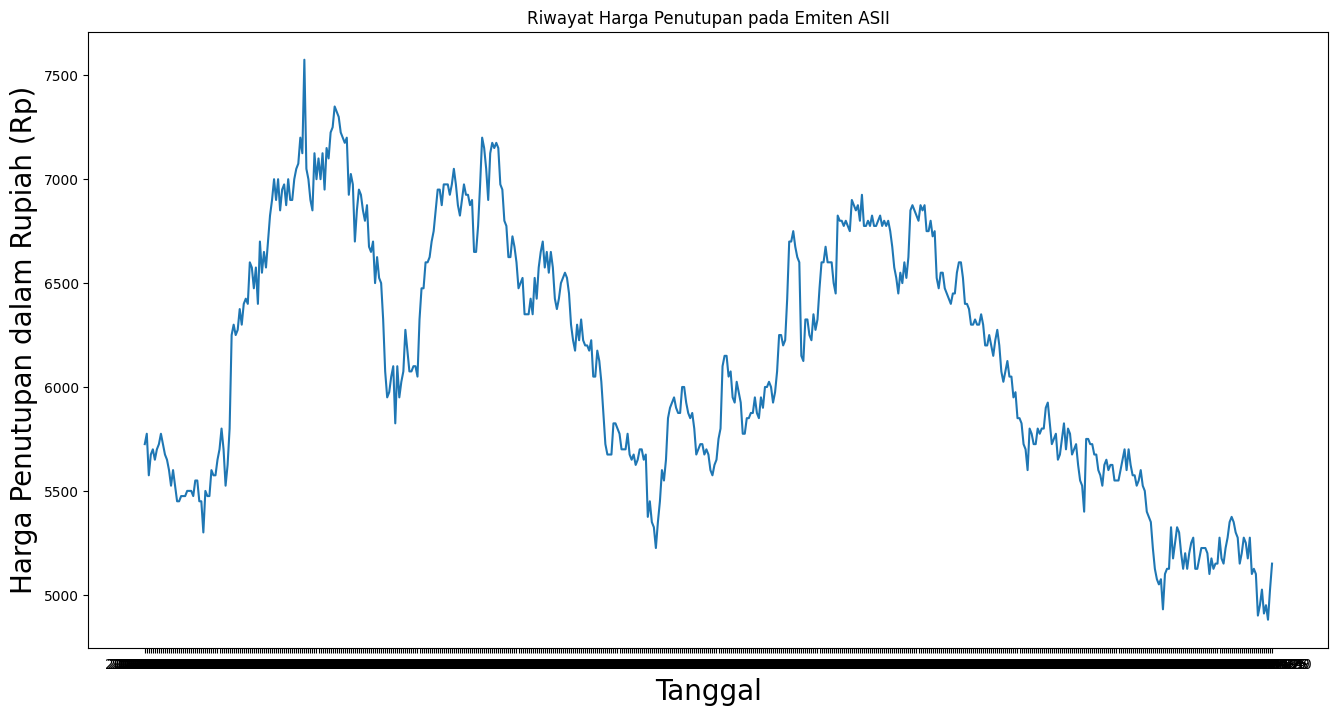

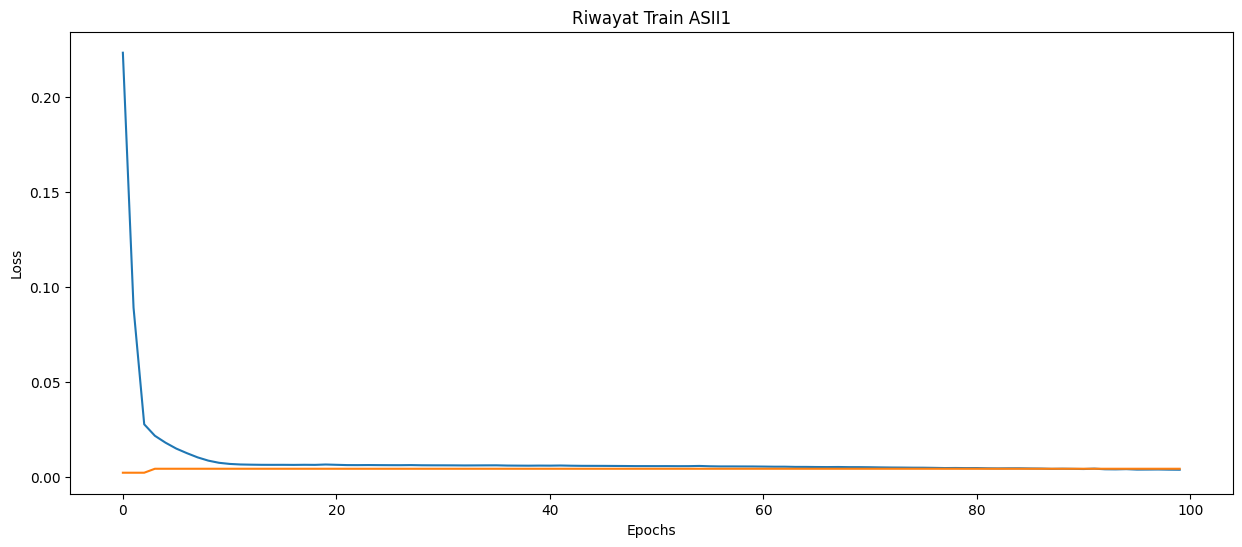

3/3 [==============================] - 1s 5ms/step


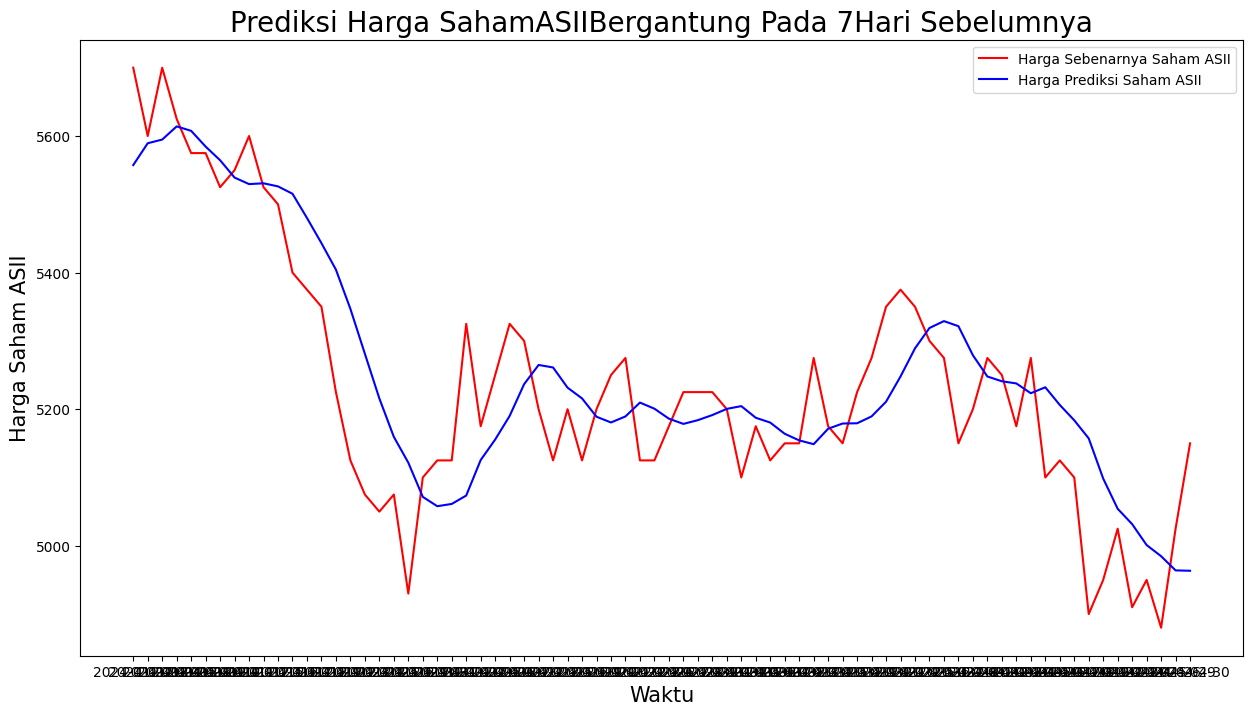

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model ASII1: 
 mse:  10134.173680266818 
 mae:  79.74328283361487 
 rmse:  100.66863305055263 
 r2:  0.6319036483764648
Epoch 1/100
15/15 [==============================] - 5s 13ms/step - loss: 0.1435 - accuracy: 0.0021
Epoch 2/100
15/15 [==============================] - 0s 13ms/step - loss: 0.0420 - accuracy: 0.0042
Epoch 3/100
15/15 [==============================] - 0s 12ms/step - loss: 0.0202 - accuracy: 0.0042
Epoch 4/100
15/15 [==============================] - 0s 12ms/step - loss: 0.0166 - accuracy: 0.0042
Epoch 5/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0137 - accuracy: 0.0042
Epoch 6/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0117 - accuracy: 0.0042
Epoch 7/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0105 - accuracy: 0.0042
Epoch 8/100
15/15 [==============================] - 0s 11ms/step - loss: 0.0099 - accuracy: 0.0042
Epoch 9/100
15/15 [==============================] - 0s 11ms/step

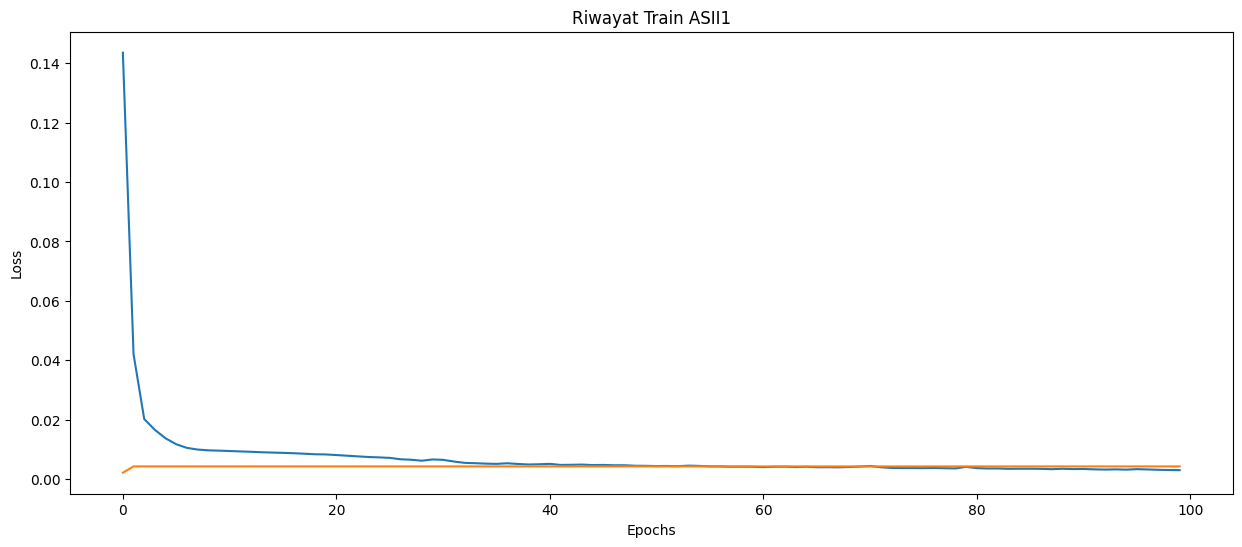

3/3 [==============================] - 1s 7ms/step


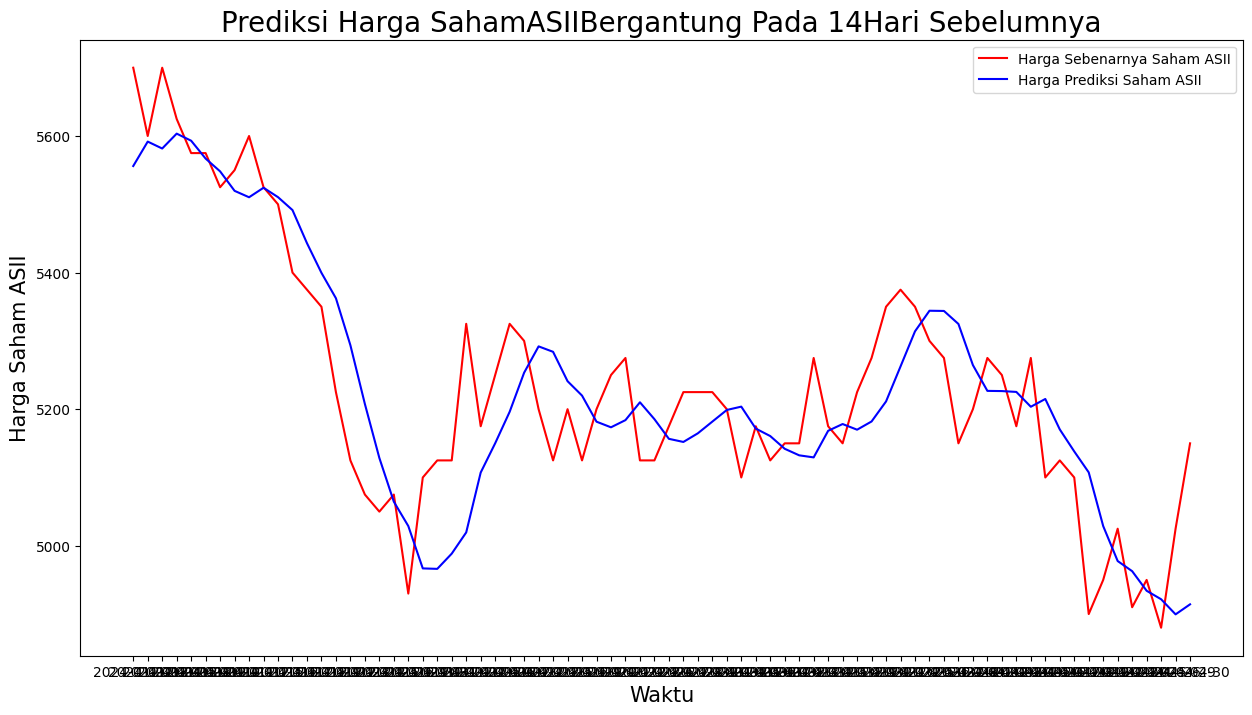

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model ASII1: 
 mse:  9276.072864815995 
 mae:  76.125 
 rmse:  96.31237129681729 
 r2:  0.7147265076637268
Epoch 1/100
15/15 [==============================] - 5s 21ms/step - loss: 0.1317 - accuracy: 0.0022
Epoch 2/100
15/15 [==============================] - 0s 19ms/step - loss: 0.0268 - accuracy: 0.0044
Epoch 3/100
15/15 [==============================] - 1s 45ms/step - loss: 0.0212 - accuracy: 0.0044
Epoch 4/100
15/15 [==============================] - 1s 41ms/step - loss: 0.0177 - accuracy: 0.0044
Epoch 5/100
15/15 [==============================] - 0s 33ms/step - loss: 0.0154 - accuracy: 0.0044
Epoch 6/100
15/15 [==============================] - 0s 28ms/step - loss: 0.0142 - accuracy: 0.0044
Epoch 7/100
15/15 [==============================] - 0s 18ms/step - loss: 0.0131 - accuracy: 0.0044
Epoch 8/100
15/15 [==============================] - 0s 20ms/step - loss: 0.0122 - accuracy: 0.0044
Epoch 9/100
15/15 [==============================] - 0s 21ms/step - loss: 0.01

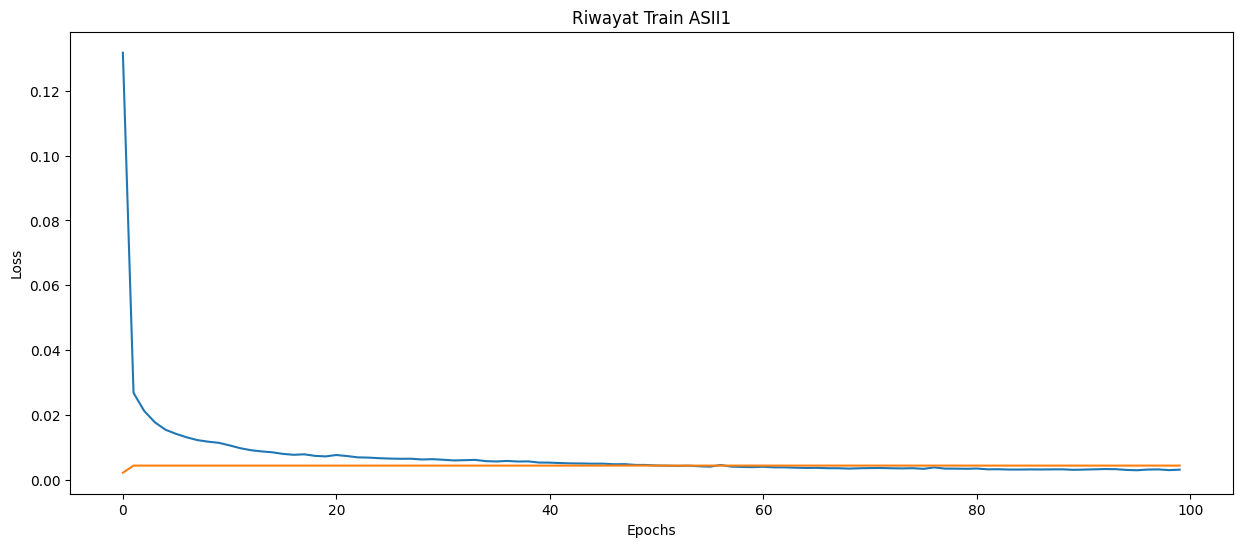

3/3 [==============================] - 1s 7ms/step


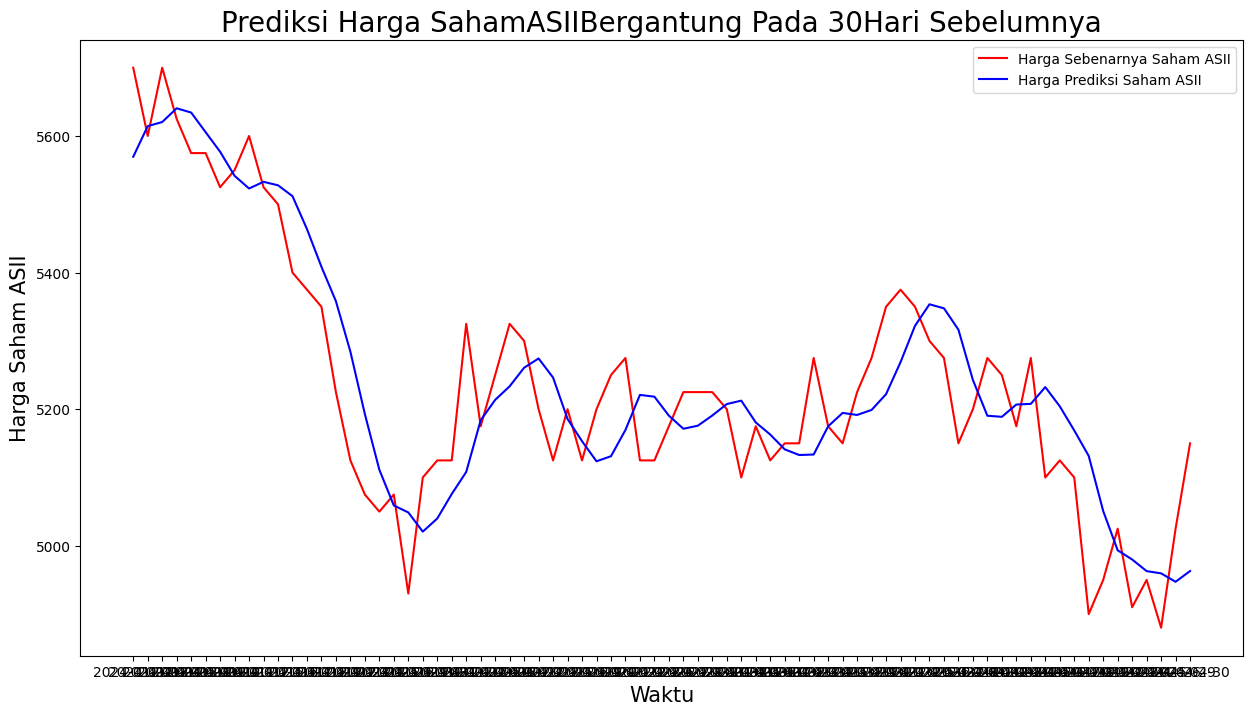

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model ASII1: 
 mse:  7561.353101984874 
 mae:  70.998779296875 
 rmse:  86.95604120465049 
 r2:  0.7615420818328857
Epoch 1/100
14/14 [==============================] - 6s 41ms/step - loss: 0.2003 - accuracy: 0.0024
Epoch 2/100
14/14 [==============================] - 1s 39ms/step - loss: 0.0590 - accuracy: 0.0024
Epoch 3/100
14/14 [==============================] - 1s 39ms/step - loss: 0.0239 - accuracy: 0.0047
Epoch 4/100
14/14 [==============================] - 1s 37ms/step - loss: 0.0198 - accuracy: 0.0047
Epoch 5/100
14/14 [==============================] - 1s 37ms/step - loss: 0.0176 - accuracy: 0.0047
Epoch 6/100
14/14 [==============================] - 1s 42ms/step - loss: 0.0151 - accuracy: 0.0047
Epoch 7/100
14/14 [==============================] - 1s 40ms/step - loss: 0.0132 - accuracy: 0.0047
Epoch 8/100
14/14 [==============================] - 1s 40ms/step - loss: 0.0117 - accuracy: 0.0047
Epoch 9/100
14/14 [==============================] - 1s 40ms/step - l

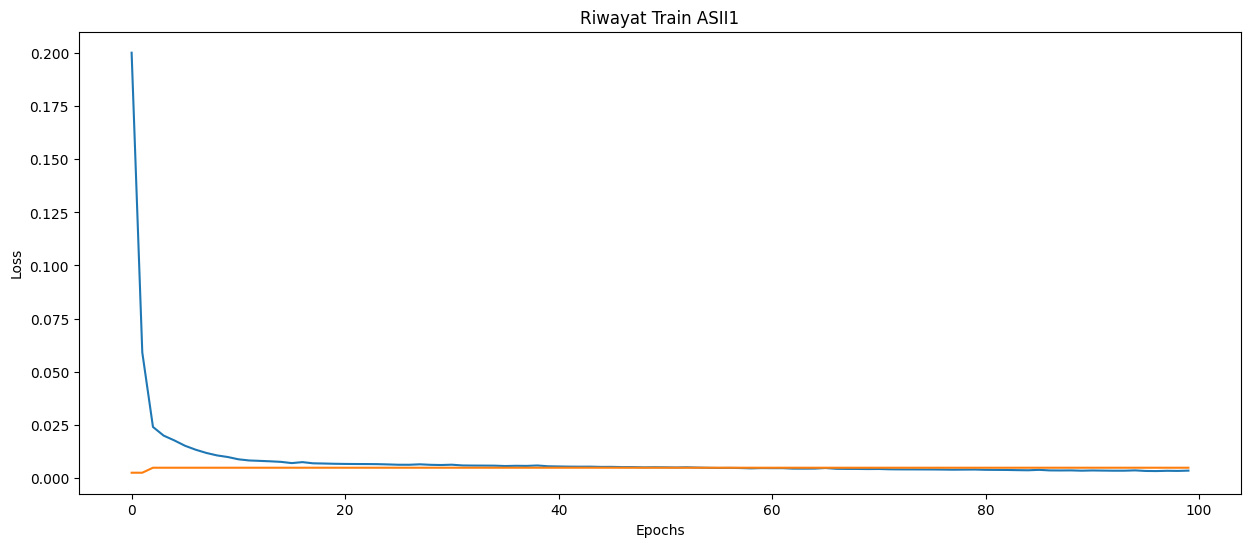

3/3 [==============================] - 1s 10ms/step


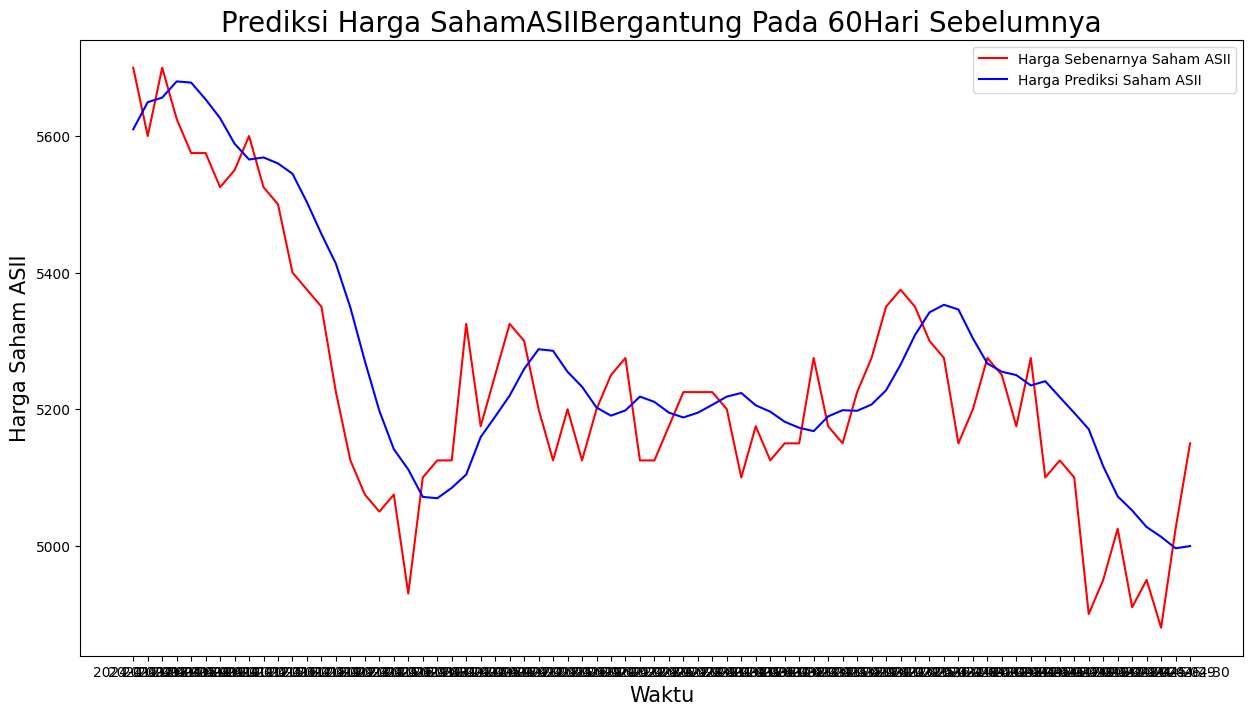

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model ASII1: 
 mse:  10450.637087300018 
 mae:  83.93957189611487 
 rmse:  102.22835754965458 
 r2:  0.6659460067749023
Epoch 1/100
10/10 [==============================] - 6s 118ms/step - loss: 0.0535 - accuracy: 0.0033
Epoch 2/100
10/10 [==============================] - 1s 115ms/step - loss: 0.0105 - accuracy: 0.0033
Epoch 3/100
10/10 [==============================] - 1s 117ms/step - loss: 0.0112 - accuracy: 0.0033
Epoch 4/100
10/10 [==============================] - 1s 115ms/step - loss: 0.0081 - accuracy: 0.0033
Epoch 5/100
10/10 [==============================] - 1s 109ms/step - loss: 0.0079 - accuracy: 0.0033
Epoch 6/100
10/10 [==============================] - 1s 115ms/step - loss: 0.0073 - accuracy: 0.0033
Epoch 7/100
10/10 [==============================] - 1s 115ms/step - loss: 0.0069 - accuracy: 0.0033
Epoch 8/100
10/10 [==============================] - 1s 110ms/step - loss: 0.0066 - accuracy: 0.0033
Epoch 9/100
10/10 [==============================] - 1s 1

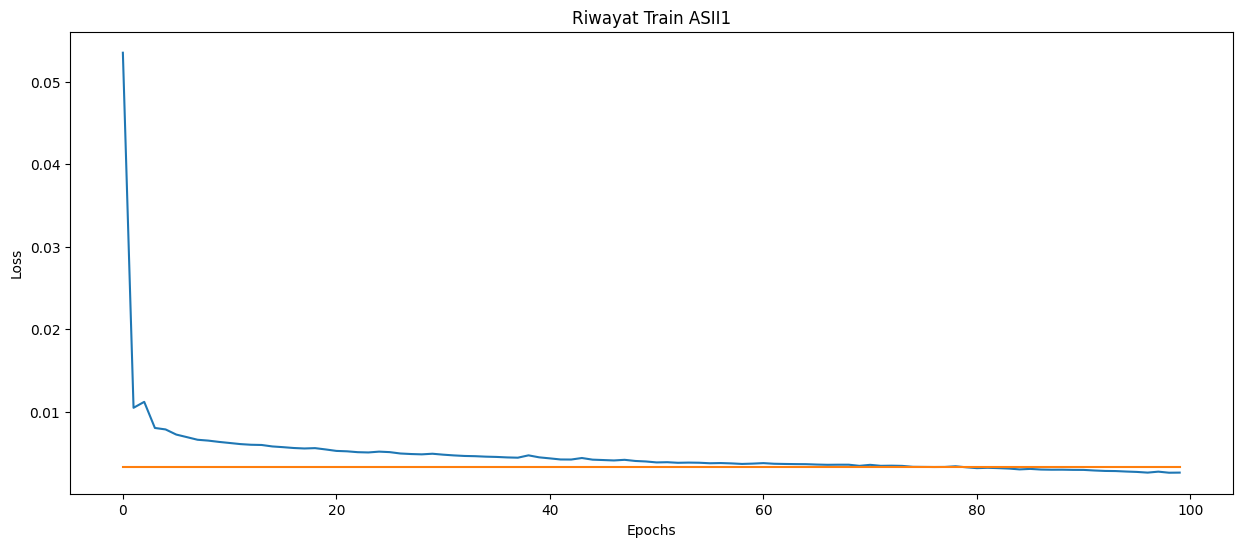

3/3 [==============================] - 2s 42ms/step


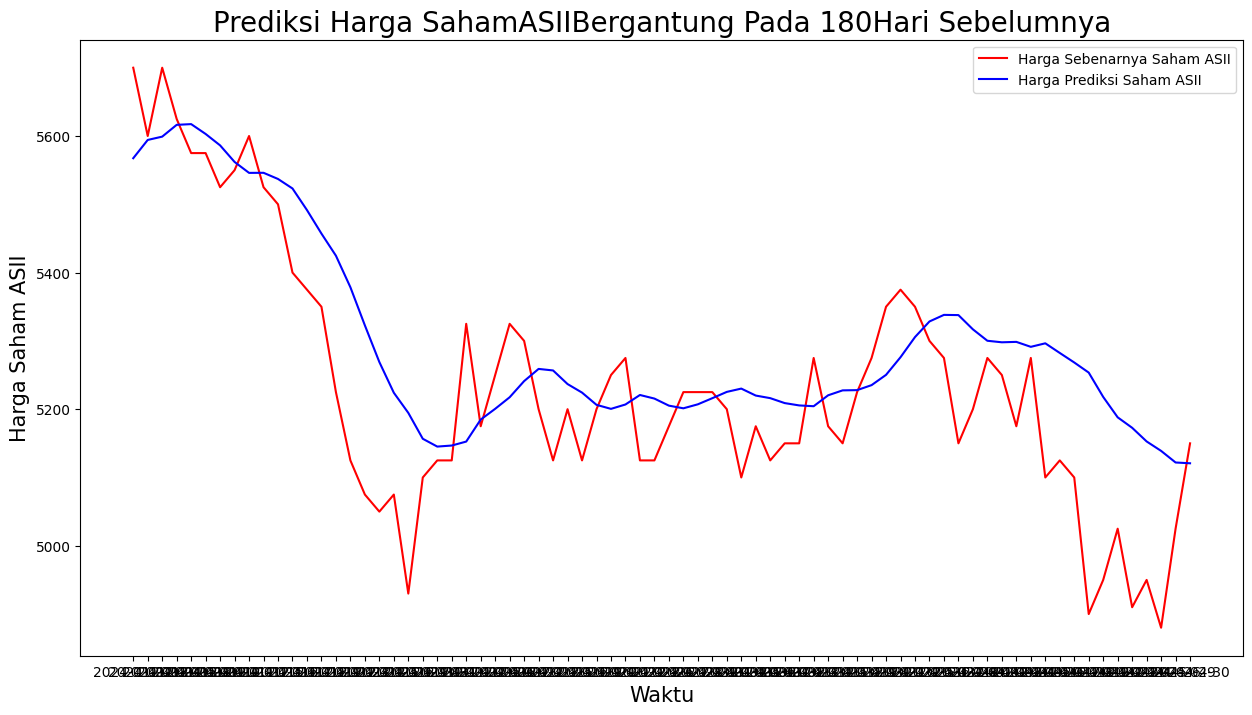

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model ASII1: 
 mse:  15411.108250009047 
 mae:  95.280029296875 
 rmse:  124.1414848066876 
 r2:  0.21828019618988037
Epoch 1/100
4/4 [==============================] - 6s 223ms/step - loss: 0.1790 - accuracy: 0.0000e+00
Epoch 2/100
4/4 [==============================] - 1s 230ms/step - loss: 0.1458 - accuracy: 0.0000e+00
Epoch 3/100
4/4 [==============================] - 1s 237ms/step - loss: 0.1126 - accuracy: 0.0000e+00
Epoch 4/100
4/4 [==============================] - 1s 243ms/step - loss: 0.0783 - accuracy: 0.0000e+00
Epoch 5/100
4/4 [==============================] - 1s 227ms/step - loss: 0.0477 - accuracy: 0.0000e+00
Epoch 6/100
4/4 [==============================] - 1s 209ms/step - loss: 0.0227 - accuracy: 0.0000e+00
Epoch 7/100
4/4 [==============================] - 1s 226ms/step - loss: 0.0152 - accuracy: 0.0000e+00
Epoch 8/100
4/4 [==============================] - 1s 241ms/step - loss: 0.0202 - accuracy: 0.0000e+00
Epoch 9/100
4/4 [==========================

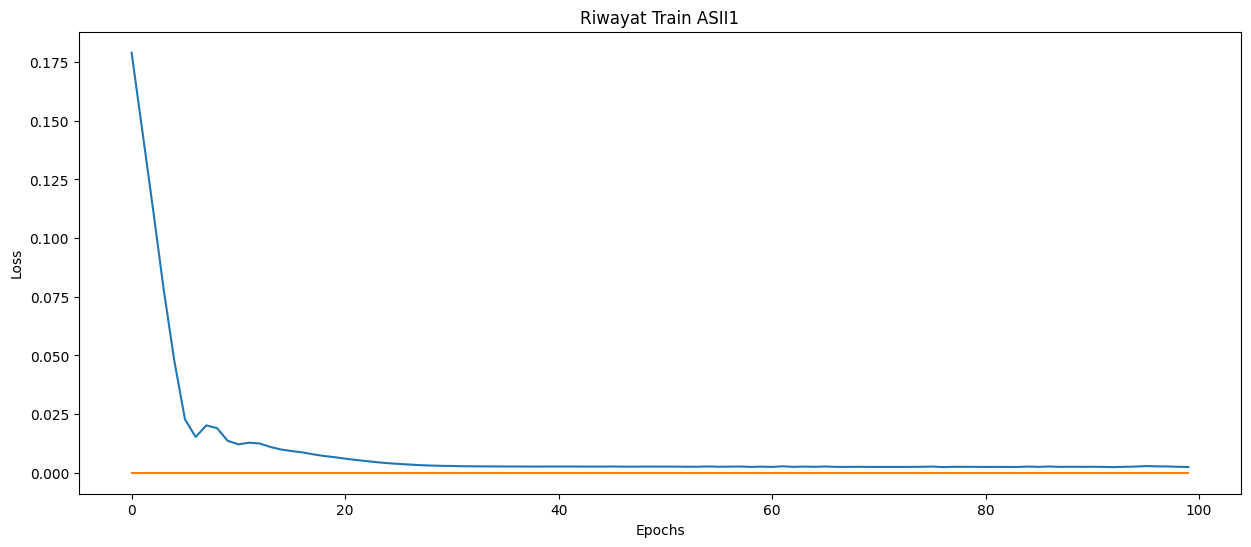

3/3 [==============================] - 1s 75ms/step


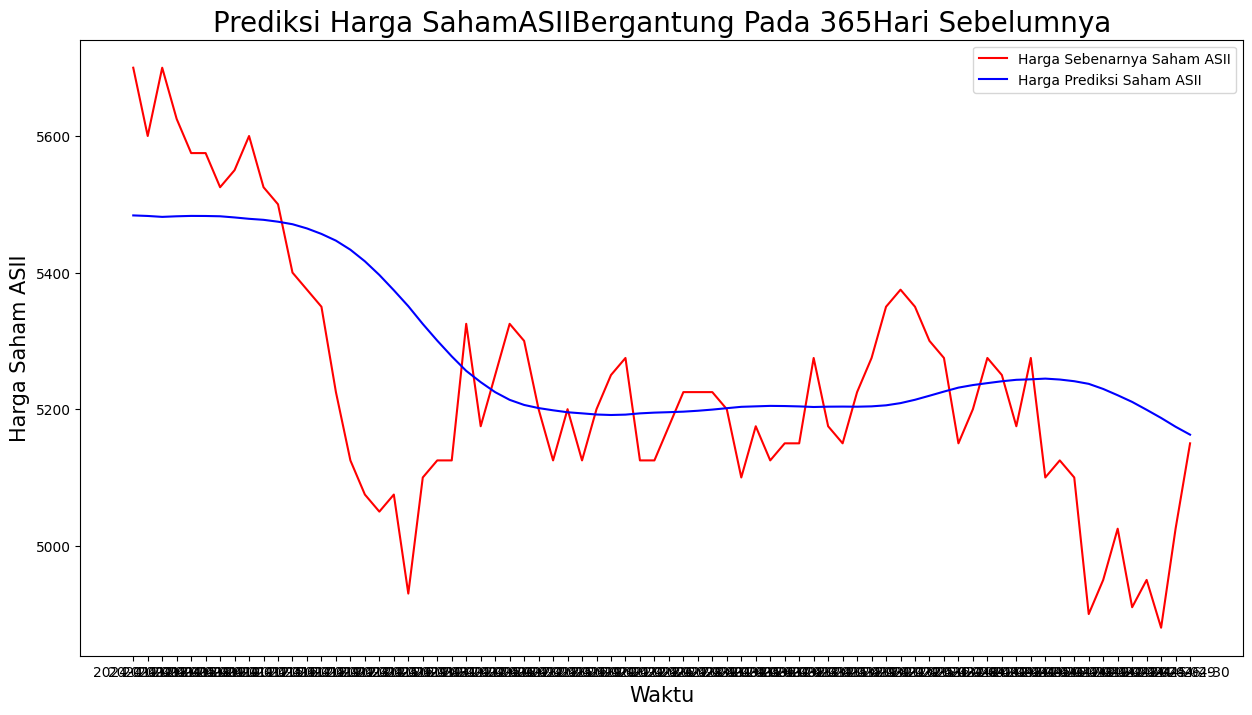

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model ASII1: 
 mse:  22877.266534228584 
 mae:  114.69620328336148 
 rmse:  151.25232736797335 
 r2:  -0.8677374124526978


{'mse': 22877.266534228584,
 'mae': 114.69620328336148,
 'rmse': 151.25232736797335,
 'accuracy_history': [0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0],
 'loss_history': [0.17899389564990997,
  0.14579686522483826,
  0.11256484687328339,
  0.07825835049152374,
  0.04769863560795784,
  0.02272556535899639,
  0.015226741321384907,
  0.020187718793

In [ ]:
df_asii = data_clean(asii_data)
test_asii = df_asii[485:]
view_data(df_asii, 'asii'.upper())
train(df_asii, 7, 'asii'.upper(), test_asii, 1, 1, 10, 0, 100)
train(df_asii, 14, 'asii'.upper(), test_asii, 1, 1, 10, 0, 100)
train(df_asii, 30, 'asii'.upper(), test_asii, 1, 1, 10, 0, 100)
train(df_asii, 60, 'asii'.upper(), test_asii, 1, 1, 10, 0, 100)
train(df_asii, 180, 'asii'.upper(), test_asii, 1, 1, 10, 0, 100)
train(df_asii, 365, 'asii'.upper(), test_asii, 1, 1, 10, 0, 100)

Epoch 1/100
15/15 [==============================] - 8s 10ms/step - loss: 0.2137 - accuracy: 0.0021
Epoch 2/100
15/15 [==============================] - 0s 10ms/step - loss: 0.1072 - accuracy: 0.0021
Epoch 3/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0368 - accuracy: 0.0042
Epoch 4/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0288 - accuracy: 0.0042
Epoch 5/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0220 - accuracy: 0.0042
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - loss: 0.0169 - accuracy: 0.0042
Epoch 7/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0123 - accuracy: 0.0042
Epoch 8/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0090 - accuracy: 0.0042
Epoch 9/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0077 - accuracy: 0.0042
Epoch 10/100
15/15 [==============================] - 0s 10ms/step - loss: 0.0076 - accuracy: 0.0042

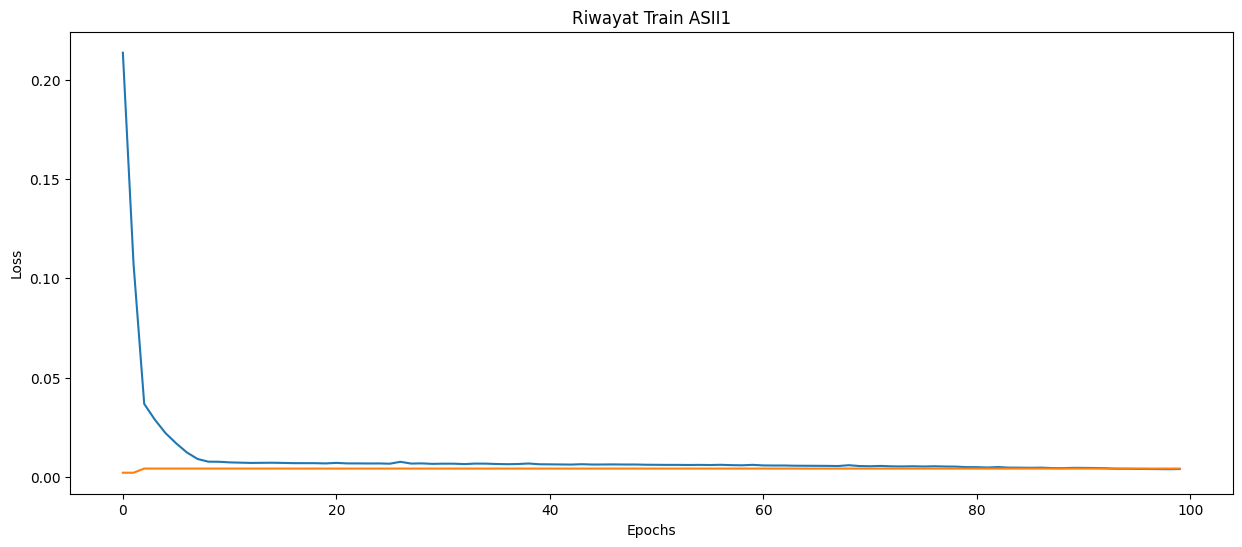

3/3 [==============================] - 3s 6ms/step


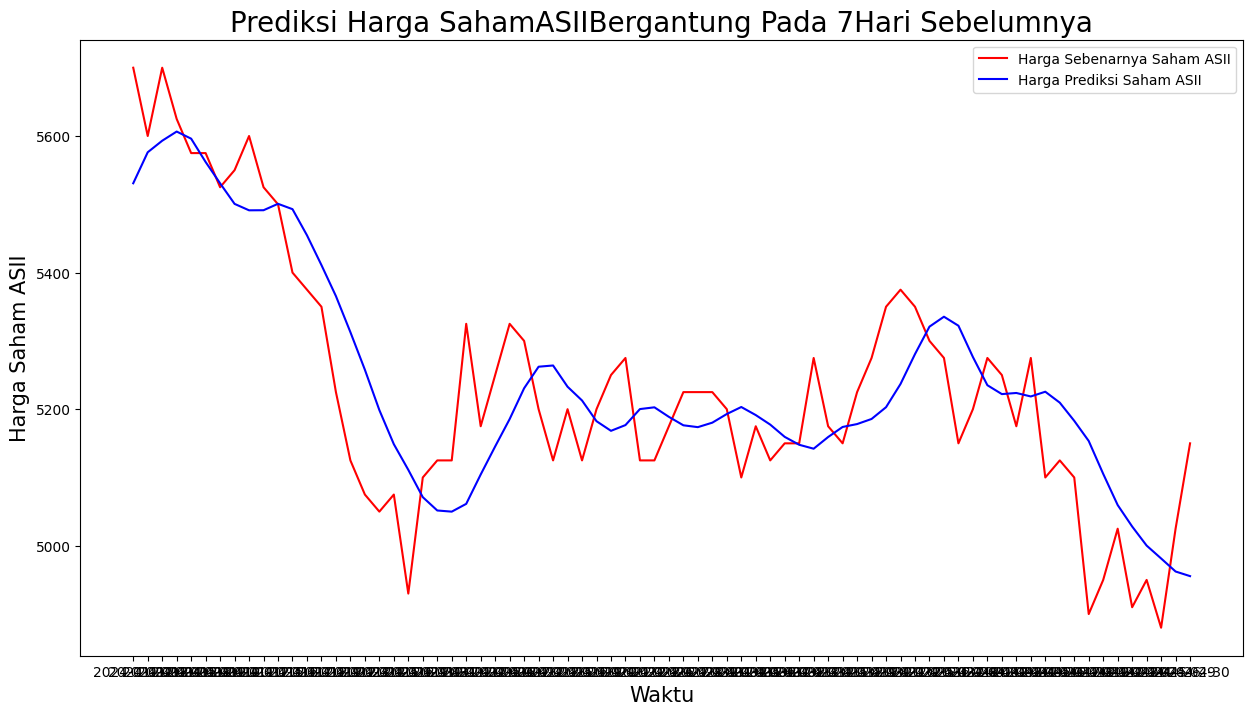

c:\Users\ThinkPad\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Hasil Evaluasi Model ASII1: 
 mse:  9957.624220993068 
 mae:  80.74035974451013 
 rmse:  99.78789616478076 
 r2:  0.6090379953384399


{'mse': 9957.624220993068,
 'mae': 80.74035974451013,
 'rmse': 99.78789616478076,
 'accuracy_history': [0.0020920501556247473,
  0.0020920501556247473,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946,
  0.0041841003112494946

In [ ]:
train(df_asii, 7, 'asii'.upper(), test_asii, 1, 1, 10, 0, 100)

In [ ]:
train(df_asii, 365, 'asii'.upper(), test_asii, 1, 5, 200, 0, 250)

Epoch 1/250
4/4 [==============================] - 54s 9s/step - loss: 0.2351 - accuracy: 0.0000e+00
Epoch 2/250
4/4 [==============================] - 41s 10s/step - loss: 0.1305 - accuracy: 0.0000e+00
Epoch 3/250
4/4 [==============================] - 39s 10s/step - loss: 0.0777 - accuracy: 0.0000e+00
Epoch 4/250
4/4 [==============================] - 41s 10s/step - loss: 0.0413 - accuracy: 0.0000e+00
Epoch 5/250
4/4 [==============================] - 40s 10s/step - loss: 0.0364 - accuracy: 0.0000e+00
Epoch 6/250
4/4 [==============================] - 40s 10s/step - loss: 0.0262 - accuracy: 0.0000e+00
Epoch 7/250
4/4 [==============================] - 40s 10s/step - loss: 0.0256 - accuracy: 0.0000e+00
Epoch 8/250


KeyboardInterrupt: 

In [ ]:
train(df_asii, 365, 'asii'.upper(), test_asii, 1, 5, 200, 0, 250,32)

TypeError: train() takes 9 positional arguments but 10 were given

In [ ]:
tensorflow.keras.utils.plot_model(model_asii1, show_shapes=True, to_file=model_name)

In [ ]:
model_load = load_model("model/ASII_unit=10_layer=1_rate_dropout=0.2.h5")


In [ ]:
inputs = df_asii['close'].values 
inputs = inputs.reshape(-1,1)
inputs = sc.fit_transform(inputs)
x_test = [] #loop dari 30 dengan ukuran data yang 485 - 30 = 455 itu
for i in range(30, inputs.shape[0]):
   x_test.append(inputs[i-30:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predict = model_load.predict(x_test)
print(predict)

17/17 [==============================] - 0s 6ms/step
[[0.22747818]
 [0.22580367]
 [0.2280572 ]
 [0.23170073]
 [0.24680619]
 [0.2603097 ]
 [0.2704009 ]
 [0.2840348 ]
 [0.30030406]
 [0.32358098]
 [0.33303502]
 [0.31710953]
 [0.30642125]
 [0.31685552]
 [0.3800644 ]
 [0.45460582]
 [0.50877005]
 [0.5424676 ]
 [0.56957376]
 [0.57440406]
 [0.5813522 ]
 [0.58829975]
 [0.5887585 ]
 [0.61280197]
 [0.6326774 ]
 [0.6310244 ]
 [0.63645667]
 [0.61772794]
 [0.63894737]
 [0.6442748 ]
 [0.6571354 ]
 [0.6572816 ]
 [0.67083746]
 [0.70074326]
 [0.7351863 ]
 [0.7720565 ]
 [0.78147084]
 [0.79235244]
 [0.7772071 ]
 [0.77342665]
 [0.77702516]
 [0.7668813 ]
 [0.7744229 ]
 [0.7699392 ]
 [0.76406795]
 [0.77440363]
 [0.79266304]
 [0.81001556]
 [0.83813405]
 [0.84771335]
 [0.9097988 ]
 [0.8898175 ]
 [0.8469001 ]
 [0.79876894]
 [0.7598923 ]
 [0.77821124]
 [0.78845495]
 [0.80802524]
 [0.8091645 ]
 [0.82283723]
 [0.8096374 ]
 [0.8224786 ]
 [0.830123  ]
 [0.85095257]
 [0.87056005]
 [0.8958112 ]
 [0.90879333]
 [0.90944

In [ ]:
df_asii.head()

,stock_code,prev,open,high,low,close,change
date,,,,,,,
2022-01-03,ASII,5700,5675,5750,5625,5725,25
2022-01-04,ASII,5725,5750,5875,5725,5775,50
2022-01-05,ASII,5775,5725,5775,5550,5575,-200
2022-01-06,ASII,5575,5600,5675,5575,5675,100
2022-01-07,ASII,5675,5725,5750,5650,5700,25


In [ ]:
print(history_asii1.history['loss'])

[0.19428162276744843, 0.037122972309589386, 0.0236746147274971, 0.018147462978959084, 0.016018353402614594, 0.014797926880419254, 0.013572760857641697, 0.012791539542376995, 0.012179678305983543, 0.011697725392878056, 0.011254907585680485, 0.010782711207866669, 0.01023829821497202, 0.00982122216373682, 0.009669995866715908, 0.00872802920639515, 0.008298931643366814, 0.00782718975096941, 0.007407142780721188, 0.007151510566473007, 0.0069059161469340324, 0.006935938727110624, 0.006670726463198662, 0.006574649829417467, 0.0064342995174229145, 0.006401000544428825, 0.006297942250967026, 0.006244442891329527, 0.006115036550909281, 0.00602709362283349, 0.0058837090618908405, 0.006139278877526522, 0.006077765952795744, 0.005718189291656017, 0.005732190329581499, 0.005907515529543161, 0.00545838288962841, 0.0054256911389529705, 0.0053954217582941055, 0.005221187602728605, 0.005182639230042696, 0.005106121767312288, 0.005027638748288155, 0.005365537479519844, 0.005160984583199024, 0.00484852446

In [ ]:
print(history_asii1.history['accuracy'])

[0.002197802299633622, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.004395604599267244, 0.0043956

In [ ]:
print(x_train_asii.shape[1])

30


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [ ]:
import tensorflow